In [1]:
! pip install astroNN
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow import keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [3]:
! pip install certifi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import sklearn
from sklearn.model_selection import train_test_split 

In [5]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [6]:


images, labels = galaxy10.load_data() 

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

features = ['Disk, Face-on, No Spiral', 'Smooth, Completely round', 'Smooth, in-between round', 'Smooth, Cigar shaped', 'Disk, Edge-on, Rounded Bulge', 'Disk, Edge-on, Boxy Bulge', 
            'Disk, Edge-on, No Bulge','Disk, Face-on, Tight Spiral', 'Disk, Face-on, Medium Spiral', 'Disk, Face-on, Loose Spiral']

x_train = x_train / 255.0
x_test = x_test / 255.0

/root/.astroNN/datasets/Galaxy10.h5 was found!


In [7]:
! pip install --upgrade certifi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
x_train.shape, x_test.shape

((17428, 69, 69, 3), (4357, 69, 69, 3))

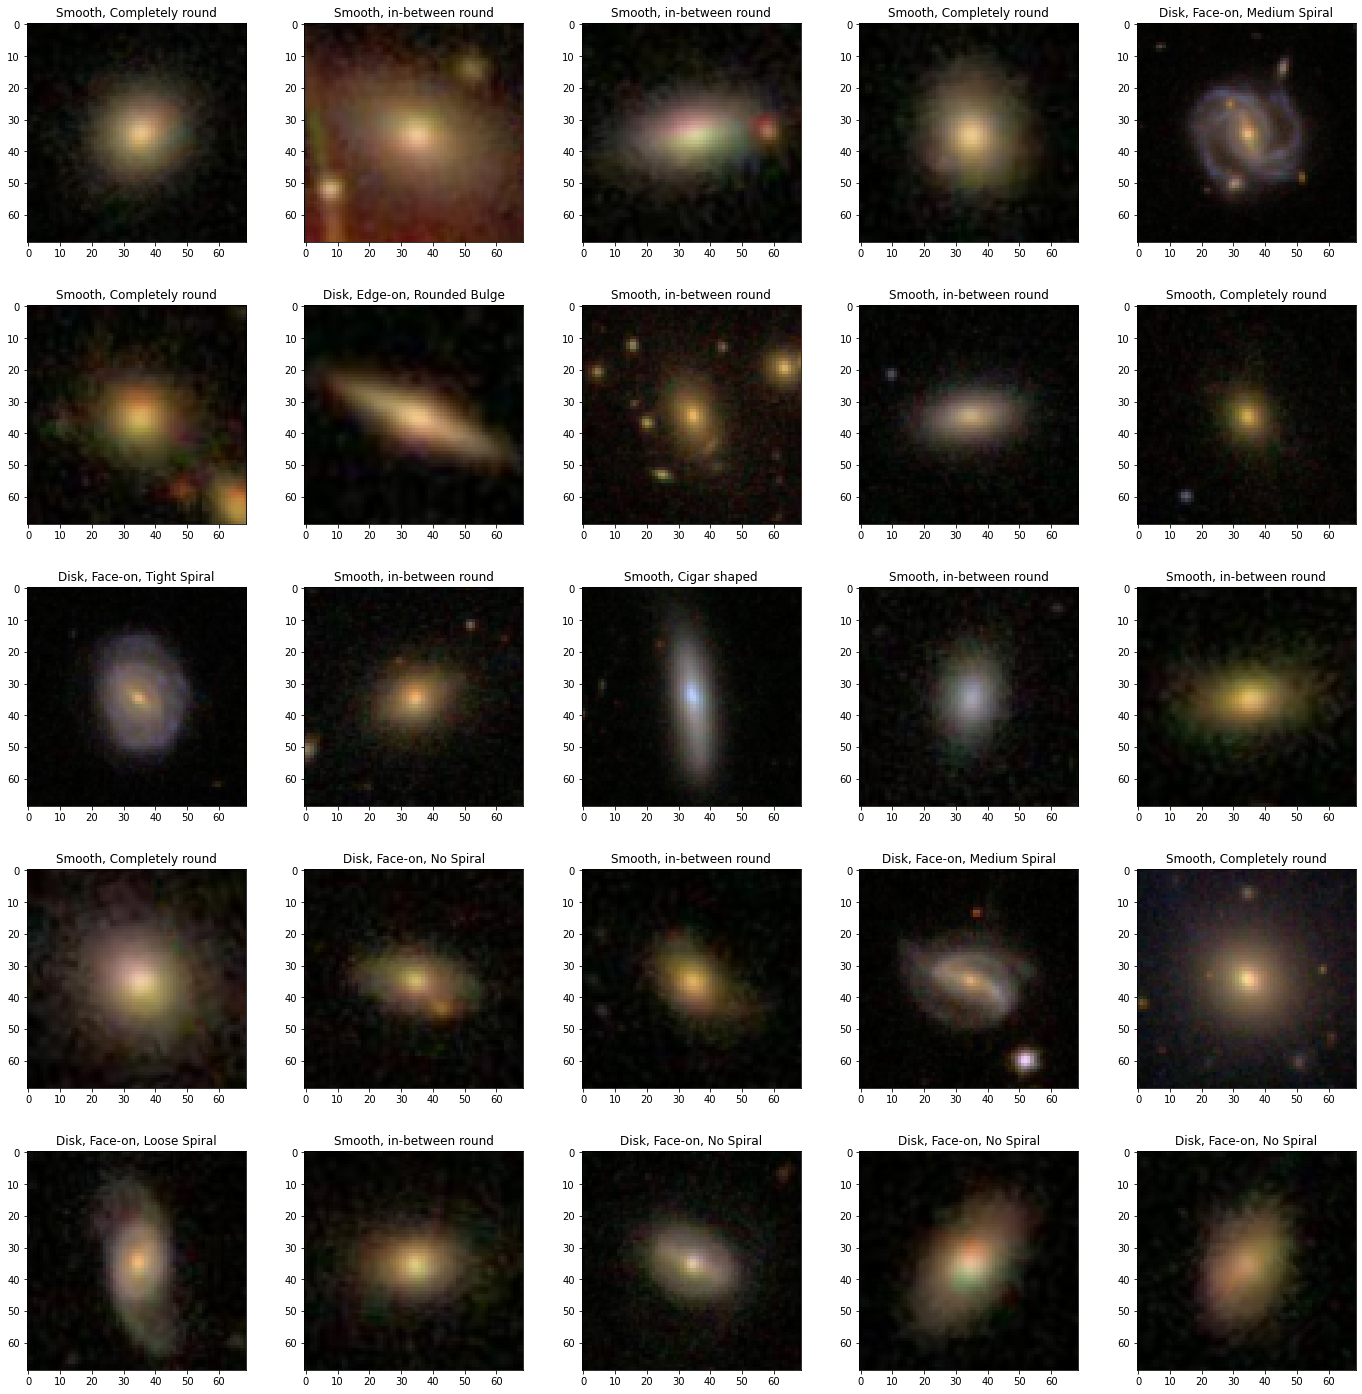

In [9]:
fig = plt.figure(figsize=(20,20)) 

for i in range(25):
    plt.subplot(5,5,i+1)    
    plt.imshow(x_train[i])
    plt.title(features[y_train[i]])
    fig.tight_layout(pad=3.0)
    
plt.show()

In [10]:
# Check class distribution

df = pd.DataFrame(data=labels)

counts = df.value_counts().sort_index()
print(counts)

0    3461
1    6997
2    6292
3     349
4    1534
5      17
6     589
7    1121
8     906
9     519
dtype: int64


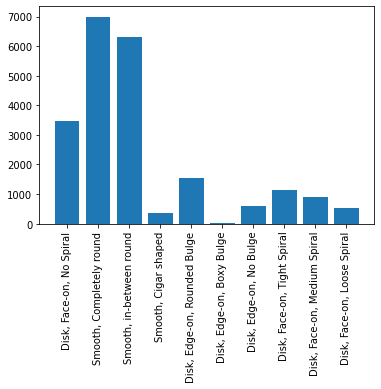

In [11]:
def class_distribution(x, y, labels):
    fig, ax = plt.subplots()
    ax.bar(x, y)
    ax.set_xticklabels(labels, rotation=90)
    plt.show()
    
class_distribution(features, counts, features)

In [12]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization
from keras.layers import concatenate, GlobalAvgPool2D, Dropout, DepthwiseConv2D ,ReLU
from keras.models import Model

import keras.backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [13]:
def mobilenet(input_shape , n_classes):

  def mobilenet_block(x , filters , strides=1):
    x = DepthwiseConv2D(3,strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

  input = Input( input_shape)
  
  #stem of the model
  x = Conv2D( filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
  

  #main part of the model
  x = mobilenet_block(x , 64 ,1)
  x = mobilenet_block(x , 128 ,2)
  x = mobilenet_block(x , 128 ,1)
  x = mobilenet_block(x , 256 ,2)
  x = mobilenet_block(x , 256 ,1)
  x = mobilenet_block(x , 512 ,2)

  for i in range(5):
    x = mobilenet_block(x, filters = 512, strides = 1)

  x = mobilenet_block(x, filters = 1024, strides = 2)
  x = mobilenet_block(x, filters = 1024, strides = 1) 
  x = GlobalAvgPool2D()(x)
  output = Dense (n_classes, activation = 'softmax')(x)

  model = Model(inputs=input, outputs=output)
  
  
  return model  

In [14]:
INPUT_SHAPE = 69, 69, 3
N_CLASSES = 10

K.clear_session()
model = mobilenet(INPUT_SHAPE , N_CLASSES)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 69, 69, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 35, 35, 32)        896       
                                                                 
 depthwise_conv2d (Depthwise  (None, 35, 35, 32)       320       
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 35, 35, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 35, 35, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 64)        2112  

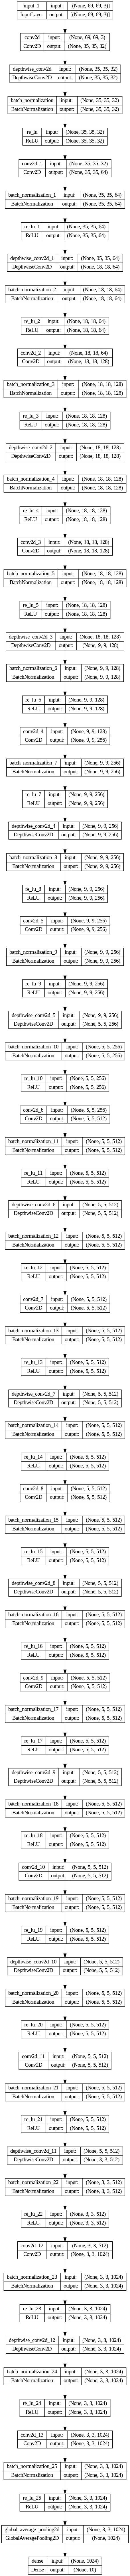

In [15]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [16]:
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras import utils



model_optimizer = Adam(lr=0.02)

model.compile(optimizer=model_optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
545/545 [==============================] - 20s 27ms/step - loss: 1.3831 - accuracy: 0.4983 - val_loss: 1.6526 - val_accuracy: 0.4666
Epoch 2/50
545/545 [==============================] - 13s 23ms/step - loss: 1.0379 - accuracy: 0.6178 - val_loss: 3.0102 - val_accuracy: 0.5173
Epoch 3/50
545/545 [==============================] - 13s 24ms/step - loss: 0.9113 - accuracy: 0.6641 - val_loss: 3.3372 - val_accuracy: 0.4044
Epoch 4/50
545/545 [==============================] - 13s 24ms/step - loss: 0.8108 - accuracy: 0.6943 - val_loss: 3.1052 - val_accuracy: 0.6084
Epoch 5/50
545/545 [==============================] - 13s 24ms/step - loss: 0.7587 - accuracy: 0.7183 - val_loss: 0.9937 - val_accuracy: 0.6954
Epoch 6/50
545/545 [==============================] - 13s 24ms/step - loss: 0.7135 - accuracy: 0.7389 - val_loss: 1.6679 - val_accuracy: 0.6661
Epoch 7/50
545/545 [==============================] - 13s 23ms/step - loss: 0.6777 - accuracy: 0.7510 - val_loss: 1.5975 - val_accuracy:

In [17]:
predict = model.predict(x_test).argmax(axis=1)

for i in range(10):
    print("Actual:", features[y_test[i]])
    print("Prediction:", features[np.argmax(predict[i])])
    print("-----")
    print()

137/137 [==============================] - 1s 5ms/step
Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, Completely round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Face-on, Tight Spiral
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Face-on, No Spiral
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Face-on, Tight Spiral
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Face-on, No Spiral
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, Completely round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----

Actual: Disk, Edge-on, Rounded Bulge
Prediction: Disk, Face-on, No Spiral
-----

Actual: Smooth, in-between round
Prediction: Disk, Face-on, No Spiral
-----



In [18]:
classification_report(y_test, predict)

'              precision    recall  f1-score   support\n\n           0       0.58      0.61      0.60       716\n           1       0.91      0.89      0.90      1413\n           2       0.82      0.91      0.86      1236\n           3       0.42      0.62      0.50        69\n           4       0.84      0.82      0.83       280\n           5       0.00      0.00      0.00         2\n           6       0.88      0.55      0.68       131\n           7       0.59      0.61      0.60       225\n           8       0.57      0.31      0.41       175\n           9       0.67      0.32      0.43       110\n\n    accuracy                           0.78      4357\n   macro avg       0.63      0.56      0.58      4357\nweighted avg       0.78      0.78      0.77      4357\n'

Text(33.0, 0.5, 'True class')

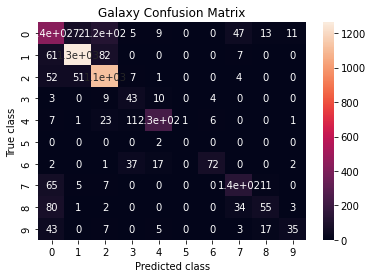

In [19]:
matrix = confusion_matrix(y_test, predict)
sns.heatmap(matrix, annot=True)
plt.title('Galaxy Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')